## Теоретическая часть

#### 1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec? <br>В чем принципиальные отличия item-item рекомендаций от ALS?


 - Рекомендации осуществляются на основе похожести пользователей для User-User фильтрации и похожести объектов (товаров) для Item-Item фильтрации. Схожесть подходов в том что по сути — это один и тот же алгоритм. Существуют различные алгоритмы. Один из них — использовать косинусное расстояние между векторами, описывающими пользователей и объекты. Отличие в том что в качестве оценки используются описания пользователей в другом случае объекты .
 -  Как говорилось выше по сути — это один и тот же алгоритм, но во втором случае необходимо использовать транспонированную матрицу  оценок (interaction_matrix)
 - Принципиальное отличие  ALS и Item-Item заключается в алгоритме предсказания. В Item-Item предсказание основывается на к-ближайших соседей, а ALS основано на факторизации матрицы interaction_matrix, объединении объектов в группы (факторы, ембединги). 
 
 

#### 2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


1. $value_w = \sum_i quantity_i * \frac{1}{1 + e^{ \alpha*(91-t)}}$, 

 - $t$ - время в неделях

 
 Смысл использования данный весов заключается в увеличении вклада покупок которые были совершены в ближайшее время и чем дальше покупка отстоит по времени тем меньше её вклад в вес
 
2. $value_w = \sum_i quantity_i * \frac{1}{\sigma*\sqrt{2\pi}}*\exp^{\frac{-(\mu - t)^2}{2\sigma^2}}$

 - $\mu$ - математическое ожидание равное 93-53

 Мы прогнозируем продажи которые буду происходить в следующие 4 недели. Продажа товаров сезонный процесс. И можно предположить что наиболее востребованные товары будут те которые продавались в это время год назад. Поэтому математическое ожидание будет вычисляться из центральной неделе предсказания 94 минус 53 (число недель в году). Стандартным отклонением регулируем ширину окна в котором покупки будут иметь наибольшую важность.
 

3. $value_w = |\{x  |  f(x)>C\}|$

 - $f(x)= x*\frac{1}{\sigma*\sqrt{2\pi}}*\exp^{\frac{-(\mu - t)^2}{2\sigma^2}}$
 - С - уровень при котором покупка исключается из множества
 - $x = quantity$
 
 Смысл формулы расчёта весов схож с пунктом 2, только в этот раз мы считаем количество фактов покупки (функция агрегации - 'count'), для этого все полученные весов ниже уровня С мы исключаем из расчёта присваивая nan
 
 
4. $value_w = |\{x  |  f(x)>C\}|$

 - $f(x)= x * \frac{1}{1 + e^{ \alpha*(91-t)}}$
 - С - уровень при котором покупка исключается из множества
 - $x = quantity$ 
 
 
5. Возможных вариантов для поиска наилучшего решения много. По аналогии можно предложить замену $f(x)$ на любую другу функцию ограничивающую покупки во времени скажем $\frac{1}{91-t}$ или иную. Так же можно изменить функцию агрегации, скажем поставить max, или mean  
 


#### 3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


тип данных - float, линейная зависимость факторов.

## Практическая часть


### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares as ALS
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys


In [2]:
import implicit
implicit.__version__

'0.5.2'

implicit.__version__ = 0.5.2

In [3]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [4]:
def get_recommendations(user, model, sp_ui, N=5):
    res = model.recommend(userid=userid_to_id[user], 
                                    user_items=sp_ui[userid_to_id[user]],   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)
    
    ress = [id_to_itemid[rec] for rec in res[0]]
    return ress

In [5]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [6]:
data_test.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0


In [7]:
result_test = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result = result_test.merge(result_train, how='left', left_on='user_id', right_on='user_id')
result.columns=['user_id', 'actual', 'actual_train']
result.head(2)


,user_id,actual,actual_train
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[825123, 831447, 840361, 845307, 852014, 85498..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[866211, 878996, 882830, 904360, 921345, 93194..."


In [8]:
from copy import deepcopy

In [9]:
data_train = deepcopy(data_train)

In [10]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

## Рассмотрим 4 варианта весов.

 
 0. Веса на основе  столбца "quantity" будем использовать этот вариант как baseline
 $$value_w = \sum_i quantity_i $$
 1. $$value_w = \sum_i quantity_i * \frac{1}{1 + e^{ \alpha*(91-t)}}$$
 2. $$value_w = \sum_i quantity_i * \frac{1}{\sigma*\sqrt{2\pi}}*\exp^{\frac{-(\mu_1 - t)^2}{2\sigma^2}}$$

 3. $$value_w = \sum_i quantity_i * \frac{1}{91-t+\epsilon}$$
 

Каждый вариант рассмотрим с 4-я случаями агрегации ['sum', 'max', 'mean', 'count']

подготовим под каждый вариант свой столбец

In [11]:
data_train['vertion_0'] = data_train['quantity']

In [12]:
data_train['vertion_0_count'] = data_train['quantity']

In [13]:
data_train['vertion_1'] = data_train['quantity'] *(1/(1+np.exp(0.2*(91-data_train['week_no']))))

In [14]:
data_train['vertion_1_count'] = data_train['quantity'] *(1/(1+np.exp(0.2*(91-data_train['week_no']))))
data_train.loc[data_train['vertion_1_count']<0.04, 'vertion_1_count'] = np.nan

In [15]:
sigma = 3
mu1 = 94-53
data_train['vertion_2'] = data_train['quantity']*(1/(sigma*np.sqrt(2*np.pi))*\
                            np.exp(-(mu1-data_train['week_no'])**2/(2*(sigma**2))))                                         

In [16]:
data_train['vertion_2_count'] = data_train['quantity']*(1/(sigma*np.sqrt(2*np.pi))*\
                            np.exp(-(mu1-data_train['week_no'])**2/(2*(sigma**2))))
data_train.loc[data_train['vertion_2_count']<0.04, 'vertion_2_count'] = np.nan

In [17]:
data_train['vertion_3'] = data_train['quantity']*(1/(91-data_train['week_no']+0.05))

In [18]:
data_train['vertion_3_count'] = data_train['quantity']*(1/(91-data_train['week_no']+0.05))
data_train.loc[data_train['vertion_3_count']<0.0, 'vertion_3_count'] = np.nan

Функции агрегеции будем перебирать в цикле, для удобства "count" вычислим отдельно

In [19]:
agrr = ['sum', 'max', 'mean']

In [20]:
def get_user_item_matrix(data_train, func, values):
    user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values=values, 
                                  aggfunc=func, 
                                  fill_value=0
                                 )
    return user_item_matrix.astype(float)

def get_dictionary(user_item_matrix):
    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))
    return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

def get_csr_matrix(user_item_matrix):
    sp_user_item = csr_matrix(user_item_matrix).tocsr()
    sp_item_user = csr_matrix(user_item_matrix).T.tocsr()
    return sp_user_item, sp_item_user

In [21]:
model = ALS(factors=44, 
                                regularization=0.01,
                                iterations=15, 
                                random_state=21,
                                calculate_training_loss=True, 
                                use_gpu=False)

C:\anaconda3\lib\site-packages\implicit\utils.py:31: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


In [22]:
precision_test = {}
precision_train = {}
for step in range(0, 4):
    values = 'vertion_'+str(step)
    precision_test[values]=[]  
    precision_train[values]=[]      
    for func in agrr:
        mx = get_user_item_matrix(data_train, func, values)
        id_to_itemid, id_to_userid, itemid_to_id, userid_to_id = get_dictionary(mx)
        csr_ui, csr_iu = get_csr_matrix(mx)
        model.fit(csr_ui)      
        result[values] = result['user_id'].\
            apply(lambda x: get_recommendations(x, model=model, sp_ui=csr_ui, N=5))     
        precision_test[values].append(result.apply(lambda row: precision_at_k(row[values], row['actual']), axis=1).mean())
        precision_train[values].append(result.apply(lambda row: precision_at_k(row[values], row['actual_train']), axis=1).mean())    

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [23]:
for step in range(0, 4):
    values = 'vertion_'+str(step)+'_count'
    mx = get_user_item_matrix(data_train, 'count', values)
    id_to_itemid, id_to_userid, itemid_to_id, userid_to_id = get_dictionary(mx)
    csr_ui, csr_iu = get_csr_matrix(mx)
    model.fit(csr_ui)
    result[values] = result['user_id'].\
            apply(lambda x: get_recommendations(x, model=model, sp_ui=csr_ui, N=5))
    precision_test[values[:-6]].append(result.apply(lambda row: precision_at_k(row[values], row['actual']), axis=1).mean())
    precision_train[values[:-6]].append(result.apply(lambda row: precision_at_k(row[values], row['actual_train']), axis=1).mean())        
#     print(values[:-6], r[values[:-6]])

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

## Значение precision_at_k в зависмости от функции весов на validation

In [24]:
total = pd.DataFrame(precision_test)
total.insert(0, 'functions', ['sum','max','mean', 'count'])
total.set_index('functions', inplace=True)
total

,vertion_0,vertion_1,vertion_2,vertion_3
functions,,,,
sum,0.169442,0.275318,0.254358,0.236043
max,0.182958,0.266014,0.240646,0.232419
mean,0.186974,0.247111,0.215965,0.211949
count,0.201371,0.302253,0.257395,0.206170


## Значение precision_at_k в зависмости от функции весов на train

In [25]:
total_train = pd.DataFrame(precision_train)
total_train.insert(0, 'functions', ['sum','max','mean', 'count'])
total_train.set_index('functions', inplace=True)
total_train

,vertion_0,vertion_1,vertion_2,vertion_3
functions,,,,
sum,0.734574,0.836337,0.891185,0.831538
max,0.812341,0.881783,0.903624,0.819295
mean,0.831244,0.891381,0.902253,0.816552
count,0.814006,0.855142,0.795397,0.818903


Вывод: 
1. Из полученных результатов видно что модели при создании модели необходимо по возможности использовать всю информацию которая имеется в датасете. Версии 1-3 учитывают помимо количественных показателей покупок еще и временную зависимость покупок. И это позволило сразу же увеличить метрики на с 0,2 до 0,3. Причём даже самая неудачная модель использующая временную информацию показывает результаты лучше чем у базовой. 
2. Использование функций агрегации 'sum','max','mean' не даёт точного ответа что же предпочтительней, в нашем примере у каждой модели это индивидуально. Поэтому на данном этапе можно сказать что выбор функции агрегации нужно осуществоять методом подбора
3. Лучший результат показал вариант 1 с функцией агрегации "count", хотя каждая из этих функций (версии 1-3) имеет много гиперпараметров которые опущены в примере (всевозможные коэффициенты и множители) подбирая которые можно улучшить результаты.

## Подбор параметров

In [26]:
import time

In [27]:
# r = {}
factors = ['regular', 140, 160, 180]
values = 'vertion_1_count'
df = pd.DataFrame([], columns=factors)
factors = factors[1:]
for regular in [15, 20, 25]:     
    regularization = []
    regularization.append(regular)
    for factor in factors:
        model = ALS(factors=factor, regularization=regular, calculate_training_loss=True, use_gpu=False, random_state=42)
        mx = get_user_item_matrix(data_train, 'count', values)
        id_to_itemid, id_to_userid, itemid_to_id, userid_to_id = get_dictionary(mx)
        csr_ui, csr_iu = get_csr_matrix(mx)
        model.fit(csr_ui)  
        result[values] = result['user_id'].\
           apply(lambda x: get_recommendations(x, model=model, sp_ui=csr_ui, N=5))
        regularization.append(result.apply(lambda row: precision_at_k(row[values], row['actual']), axis=1).mean())
    df.loc[len(df)] = regularization

df.set_index('regular', inplace=True)
df

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

,140,160,180
regular,,,
15.0,0.349070,0.351812,0.355926
20.0,0.352106,0.351616,0.352595
25.0,0.339373,0.340157,0.340157


Оптимальный параметры factors=160, regularization=20, 
С точки зрения регуляризации оптимум выражается относительно чётко. 
А вот зависимость precision_at_k от n_factors монотонно увеличивающаяся функция, при малых значениях n_factors precision_at_k растёт быстро, но потом рост асимптотически замедляется, поэтому выбор оптимального значения n_factors следует выбирать в точке замедления роста.

In [28]:
time_ = []
precision_test=[]
precision_train=[]
reg = [0.01, 0.1, 1, 10, 20, 50, 100]
for regular in reg:
        model = ALS(factors=160, regularization=regular, calculate_training_loss=True, use_gpu=False, random_state=42)
        mx = get_user_item_matrix(data_train, 'count', values)
        id_to_itemid, id_to_userid, itemid_to_id, userid_to_id = get_dictionary(mx)
        csr_ui, csr_iu = get_csr_matrix(mx)
        start = time.time()
        model.fit(csr_ui)     
        end = time.time()
        time_.append(end - start)
        result[values] = result['user_id'].\
                   apply(lambda x: get_recommendations(x, model=model, sp_ui=csr_ui, N=5))
        precision_test.append(result.apply(lambda row: precision_at_k(row[values], row['actual']), axis=1).mean())
        precision_train.append(result.apply(lambda row: precision_at_k(row[values], row['actual_train']), axis=1).mean())        
        


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

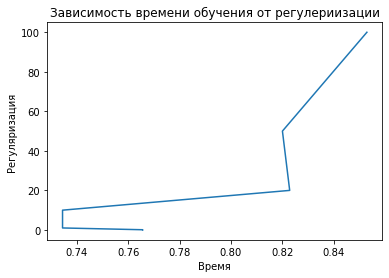

In [29]:
plt.plot(time_, reg)
plt.title('Зависимость времени обучения от регулериизации')
plt.xlabel("Время")
plt.ylabel("Регуляризация")
plt.show()

Время обучения модели не зависит от величины регуляризации, потому что величина не влияет на объём вычислений

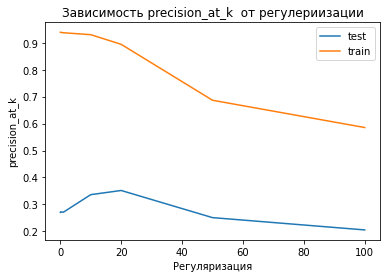

In [30]:
plt.plot(reg, precision_test, label="test")
plt.plot(reg, precision_train, label="train")
plt.title('Зависимость precision_at_k  от регулериизации')
plt.ylabel("precision_at_k")
plt.xlabel("Регуляризация")
plt.legend()
plt.show()

Вид графиков соответствует ожидаемым. После достижения оптимального значения величины регуляризации точность модели начинает падать. 

In [31]:
time_ = []
precision_test=[]
precision_train=[]
factors = [10, 50, 100, 150, 250, 500]
for factor in factors:
        model = ALS(factors=factor, regularization=20, calculate_training_loss=True, use_gpu=False, random_state=42)
        mx = get_user_item_matrix(data_train, 'count', values)
        id_to_itemid, id_to_userid, itemid_to_id, userid_to_id = get_dictionary(mx)
        csr_ui, csr_iu = get_csr_matrix(mx)
        start = time.time()
        model.fit(csr_ui)
        end = time.time()
        time_.append(end - start)
        result[values] = result['user_id'].\
                   apply(lambda x: get_recommendations(x, model=model, sp_ui=csr_ui, N=5))
        precision_test.append(result.apply(lambda row: precision_at_k(row[values], row['actual']), axis=1).mean()) 
        precision_train.append(result.apply(lambda row: precision_at_k(row[values], row['actual_train']), axis=1).mean())  
        

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

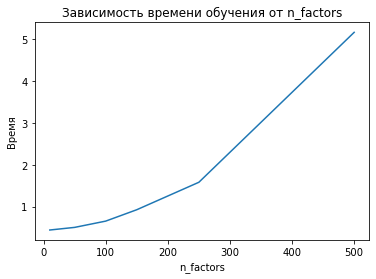

In [32]:
plt.plot(factors, time_)
plt.title('Зависимость времени обучения от n_factors')
plt.ylabel("Время")
plt.xlabel("n_factors")
plt.show()

С ростом параметра растёт размерность матриц при факторизации, а следовательно, возрастает объём и время вычислений 

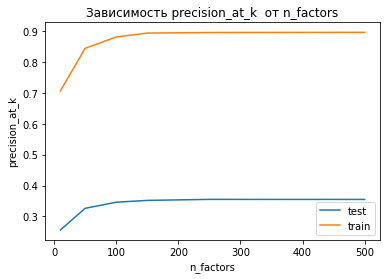

In [33]:
plt.plot(factors, precision_test, label="test")
plt.plot(factors, precision_train, label = "train")
plt.title('Зависимость precision_at_k  от n_factors')
plt.ylabel("precision_at_k")
plt.xlabel("n_factors")
plt.legend()
plt.show()

Из графика видно что ALS не подвергается переобучению. А временные затраты растут практически линейно с ростом параметра n_factors. Таким образом можно сделать вывод - определение оптимального значения необходимо осуществлять в точке прекращения быстрого роста точности, а также брать во внимание время (вычислительные ресурсы) которое вы готовы потратить на обучение модели. 

В ходе работы столкнулся с нестабильность работы random_state. Каждый новый запуск давал некоторые отличия от предыдущего. Объяснить это не смог. 